# MVP Award Prediction

## Data Preprocessing

Import general preprocessed data

In [1]:
%run Preprocessing_main.ipynb

In [2]:
MVP_data['G_x'] = MVP_data['G_x'].astype(int)

Dropping redundant columns (columns having correlation over 90%)

In [3]:
def drop_col(data):
    corr = data.corr()
    NEW_data = data
    del_list = []
    del_col = []
    for i in corr:
        for ind in corr[(corr[i]>0.9)&(corr[i]<1)].index:
            if ind not in del_list:
                try:
                    NEW_data = NEW_data.drop(ind, axis = 1)
                    del_col.append(ind)
                except:
                    continue
        del_list.append(i)
    NEW_data = NEW_data.drop('Player', axis = 1)
    return NEW_data, del_col

In [4]:
NEW_data, del_col = drop_col(MVP_data)

### Standardize for analysis

Due to the selection of NBA awards were base on the comparison of players' performances each year. We split the data by year, standardized it, and finally combined them together. This provides a more reasonable indication of players' performance.

In [5]:
# standardize through years
def std_scale_split(data, year_names):
    scaler = StandardScaler()
    X_train_result = pd.DataFrame()
    X_test_result = pd.DataFrame()
    y_train_result = pd.DataFrame()
    y_test_result = pd.DataFrame()
    for i in year_names:
        
        data_year = data[data['year_y']==i]
        data_year = data_year.drop(columns='year_y')
        
        X = data_year.iloc[:, :-1]
        y = data_year.iloc[:, -1]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
        train_scaled = scaler.fit_transform(X_train)
        test_scaled = scaler.transform(X_test)
        
        X_train_result = pd.concat([X_train_result, pd.DataFrame(train_scaled)])
        X_test_result = pd.concat([X_test_result, pd.DataFrame(test_scaled)])
        y_train_result = pd.concat([y_train_result, y_train])
        y_test_result = pd.concat([y_test_result, y_test])
        
    return X_train_result, X_test_result, y_train_result, y_test_result

X_train, X_test, y_train, y_test = std_scale_split(NEW_data, year_names)

## Model Implementation

### Model 1 : Linear Regression

In [6]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
regressionSummary(y_train, y_train_pred)
regressionSummary(y_test, y_pred)
lin_mse = mean_squared_error(y_test, y_pred)
comp = pd.DataFrame({0: y_test[0], 1: y_pred.reshape(len(y_pred))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_lin = y_pred_sorted


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.1983
            Mean Absolute Error (MAE) : 0.1541
          Mean Percentage Error (MPE) : -480.8082
Mean Absolute Percentage Error (MAPE) : 3054.9236

Regression statistics

                      Mean Error (ME) : -0.0171
       Root Mean Squared Error (RMSE) : 0.1603
            Mean Absolute Error (MAE) : 0.1254
          Mean Percentage Error (MPE) : -192.2601
Mean Absolute Percentage Error (MAPE) : 922.2176


In [7]:
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
lin_cor = cor[1, 0]

### Model 2 : Support Vector Regression

In [8]:
regressor = SVR()
regressor.fit(X = X_train, y = y_train)
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
regressionSummary(y_train, y_train_pred)
regressionSummary(y_test, y_pred)
SVR_mse = mean_squared_error(y_test, y_pred)
comp = pd.DataFrame({0: y_test[0], 1: y_pred.reshape(len(y_pred))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_SVR = y_pred_sorted


Regression statistics

                      Mean Error (ME) : -0.0128
       Root Mean Squared Error (RMSE) : 0.1078
            Mean Absolute Error (MAE) : 0.0824
          Mean Percentage Error (MPE) : -1233.9688
Mean Absolute Percentage Error (MAPE) : 1890.8296

Regression statistics

                      Mean Error (ME) : -0.0461
       Root Mean Squared Error (RMSE) : 0.2011
            Mean Absolute Error (MAE) : 0.1626
          Mean Percentage Error (MPE) : -1089.9168
Mean Absolute Percentage Error (MAPE) : 1289.5220


In [9]:
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
SVR_cor = cor[1, 0]

### Model 3 : Decision Tree Regression

In [10]:
fin_alpha = 0
min_mse = 1E20
fin_cor = -1
for alpha in np.linspace(0, 0.5, 21):
    regressor = DecisionTreeRegressor(ccp_alpha = alpha, random_state = 1)
    regressor.fit(X = X_train, y = np.array(y_train).reshape(len(y_train), ))
    y_pred = regressor.predict(X_test)
    y_train_pred = regressor.predict(X_train)
    MSE = mean_squared_error(y_test, y_pred)
    cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
    if cor[1, 0] > fin_cor:
        fin_alpha = alpha
        fin_cor = cor[1, 0]
        y_pred_tree = y_pred
print('alpha: {:1.4f}, CORR: {:1.4f}'.format(fin_alpha, fin_cor))
tree_cor = fin_cor
comp = pd.DataFrame({0: y_test[0], 1: y_pred_tree.reshape(len(y_pred_tree))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_tree = y_pred_sorted

alpha: 0.0250, CORR: 0.3836


### Model 4 : Random Forest Regression

In [11]:
min_mse = 1E20
fin_alpha = 0
fin_NE = 0
fin_cor = -1

for alpha in np.linspace(0, 0.5, 11):
    for n_e  in np.linspace(10, 100, 10):
        regressor = RandomForestRegressor(n_estimators = int(n_e), ccp_alpha = alpha, random_state = 1)
        regressor.fit(X = X_train, y = np.array(y_train).reshape(len(y_train), ))
        y_pred = regressor.predict(X_test)
        y_train_pred = regressor.predict(X_train)
        MSE = mean_squared_error(y_test, y_pred)
        cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
        if cor[1, 0] > fin_cor:
            fin_alpha = alpha
            fin_cor = cor[1, 0]
            y_pred_for = y_pred
print('alpha: {:1.4f}, CORR: {:1.4f}'.format(fin_alpha, fin_cor))
for_cor = fin_cor
comp = pd.DataFrame({0: y_test[0], 1: y_pred_for.reshape(len(y_pred_for))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_for = y_pred_sorted

alpha: 0.0500, CORR: 0.4273


In [12]:
fin_NE

0

### Model 5 : Neural Network

For neural network, the input data is scaled between 0 and 1.

In [13]:
# standardize through years
def nor_scale_split(data, year_names):
    scaler = MinMaxScaler()

    X_train_result = pd.DataFrame()
    X_test_result = pd.DataFrame()
    y_train_result = pd.DataFrame()
    y_test_result = pd.DataFrame()
    for i in year_names:
        
        data_year = data[data['year_y']==i]
        data_year = data_year.drop(columns='year_y')
        
        X = data_year.iloc[:, :-1]
        y = data_year.iloc[:, -1]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
        train_scaled = scaler.fit_transform(X_train)
        test_scaled = scaler.transform(X_test)
        
        X_train_result = pd.concat([X_train_result, pd.DataFrame(train_scaled)])
        X_test_result = pd.concat([X_test_result, pd.DataFrame(test_scaled)])
        y_train_result = pd.concat([y_train_result, y_train])
        y_test_result = pd.concat([y_test_result, y_test])
        
    return X_train_result, X_test_result, y_train_result, y_test_result

X_train, X_test, y_train, y_test = nor_scale_split(NEW_data, year_names)

Selecting the best parameter for the neural network model

In [14]:
best_cor = 0
best_bat = 0
best_size = 0

for size1 in [int(i) for i in np.linspace(5, 20, 16)]:
    for bat in [int(i) for i in np.linspace(0, 100, 21)]:
        NNRegressor = MLPRegressor(hidden_layer_sizes = (size1), batch_size = bat, 
                                   activation = 'logistic', random_state= 1)
        NNRegressor.fit(X_train, y_train)
        y_pred = NNRegressor.predict(X_test)
        NN_cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
        NN_cor = NN_cor[1, 0]
        if NN_cor > best_cor:
            best_cor = NN_cor
            best_size = size1
            best_bat = bat
            y_pred_NN = y_pred
print('layer size: {:1.4f}, batch size: {:1.4f}, CORR: {:1.4f}'.format(best_size, best_bat, best_cor))
NN_cor = best_cor
comp = pd.DataFrame({0: y_test[0], 1: y_pred_NN.reshape(len(y_pred_NN))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_NN = y_pred_sorted

layer size: 16.0000, batch size: 45.0000, CORR: 0.6534


### Model Comparison Using Correlation Coefficient and Lift Chart

In [15]:
print('Linear regression: {:1.4f}'.format(lin_cor))
print('SVR: {:1.4f}'.format(SVR_cor))
print('Decision tree: {:1.4f}'.format(tree_cor))
print('Random forest: {:1.4f}'.format(for_cor))
print('Neural Network: {:1.4f}'.format(NN_cor))

Linear regression: 0.6673
SVR: 0.4868
Decision tree: 0.3836
Random forest: 0.4273
Neural Network: 0.6534


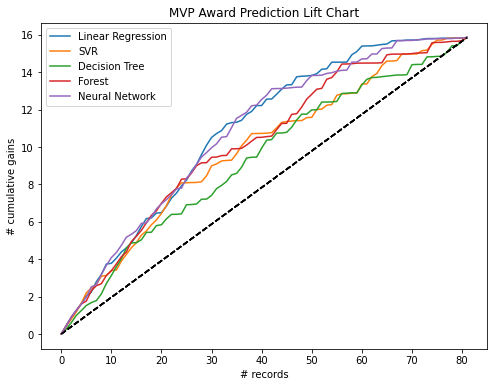

In [16]:
ax = gainsChart(pd.Series(y_pred_lin), label = 'Linear Regression',figsize = [8, 6], color = 'C0')
ax = gainsChart(pd.Series(y_pred_SVR), label = 'SVR', ax = ax, color = 'C1')
ax = gainsChart(pd.Series(y_pred_tree), label = 'Decision Tree', ax = ax, color = 'C2')
ax = gainsChart(pd.Series(y_pred_for), label = 'Forest', ax = ax, color = 'C3')
ax = gainsChart(pd.Series(y_pred_NN), label = 'Neural Network', ax = ax, color = 'C4')
plt.title('MVP Award Prediction Lift Chart')
plt.legend()
plt.show()

# Evaluation

## Linear Regression

### Summary

In [17]:
# preprocessing
X_train, X_test, y_train, y_test = std_scale_split(NEW_data, year_names)

# build model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# model summary
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

print('Model: linear regression\n')
regressionSummary(y_test, y_pred)

# evaluations
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
lin_cor = cor[1, 0]

lin_RMSE = mean_squared_error(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))**0.5
print('\nCORR: {:1.4f}'.format(lin_cor))
print('RMSE: {:1.4f}'.format(lin_RMSE))

Model: linear regression


Regression statistics

                      Mean Error (ME) : -0.0171
       Root Mean Squared Error (RMSE) : 0.1603
            Mean Absolute Error (MAE) : 0.1254
          Mean Percentage Error (MPE) : -192.2601
Mean Absolute Percentage Error (MAPE) : 922.2176

CORR: 0.6673
RMSE: 0.1603


### Visualization

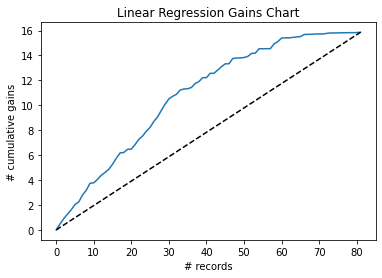

In [18]:
ax = gainsChart(pd.Series(y_pred_lin), label = 'Linear regression')
plt.title('Linear Regression Gains Chart')
plt.show()

## Neural network

In [19]:
# preprocessing
X_train, X_test, y_train, y_test = nor_scale_split(NEW_data, year_names)

# build model
NN = MLPRegressor(hidden_layer_sizes = (16), batch_size = 45, 
                                   activation = 'logistic', random_state= 1)
NN.fit(X_train, y_train)

# model summary
y_pred = NN.predict(X_test)
y_train_pred = NN.predict(X_train)

print('Model: Neural network\n')
regressionSummary(y_test, y_pred)

# evaluations
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
NN_cor = cor[1, 0]

NN_RMSE = mean_squared_error(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))**0.5
print('\nCORR: {:1.4f}'.format(NN_cor))
print('RMSE: {:1.4f}'.format(NN_RMSE))

Model: Neural network


Regression statistics

                      Mean Error (ME) : -0.0010
       Root Mean Squared Error (RMSE) : 0.1532
            Mean Absolute Error (MAE) : 0.1210
          Mean Percentage Error (MPE) : -159.7415
Mean Absolute Percentage Error (MAPE) : 1077.7663

CORR: 0.6534
RMSE: 0.1532


### Visualization

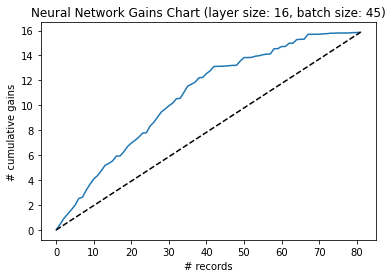

In [20]:
ax = gainsChart(pd.Series(y_pred_NN), label = 'Neural Network')
plt.title('Neural Network Gains Chart (layer size: 16, batch size: 45)')
plt.show()

# Prediction

In [21]:
data_2022['G_x'] = data_2022['G_x'].astype(int)
NEW_2022 = data_2022.drop(del_col, axis = 1)
NEW_2022 = NEW_2022.drop('Rk', axis = 1)
player_list = NEW_2022['Player']
NEW_2022 = NEW_2022.drop('Player', axis = 1)

In [22]:
scaler = StandardScaler()
scaled_2022 = scaler.fit_transform(NEW_2022)
pred_22_lin = regressor.predict(scaled_2022)

In [23]:
scaler = MinMaxScaler()
scaled_2022 = scaler.fit_transform(NEW_2022)
pred_22_NN = NN.predict(scaled_2022)

In [24]:
NEW_2022['Player'] = player_list
NEW_2022['share_lin'] = pred_22_lin
NEW_2022['share_NN'] = pred_22_NN

#### Linear regression prediction

In [25]:
NEW_2022.sort_values('share_lin', ascending=False).head(5)[['Player', 'share_lin']]

,Player,share_lin
715,Nikola Jokić\jokicni01,1.043004
27,Giannis Antetokounmpo\antetgi01,0.941525
1292,Jayson Tatum\tatumja01,0.805944
1470,Trae Young\youngtr01,0.796768
292,Luka Dončić\doncilu01,0.794076


#### Neural network prediction

In [26]:
NEW_2022.sort_values('share_NN', ascending=False).head(5)[['Player', 'share_NN']]

,Player,share_NN
715,Nikola Jokić\jokicni01,0.578886
27,Giannis Antetokounmpo\antetgi01,0.535241
292,Luka Dončić\doncilu01,0.482910
344,Joel Embiid\embiijo01,0.480215
1292,Jayson Tatum\tatumja01,0.419424


Both model predicted player *Nikola Jokic* to win the MVP award